In [1]:
import numpy as np
from typing import Union
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import (
    layers,
    losses,
    metrics,
    datasets,
    mixed_precision,
    optimizers,
)

mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A6000, compute capability 8.6


2022-01-25 20:46:10.179720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 20:46:10.209688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 20:46:10.211015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 20:46:10.212844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
RESIZE_TO = 72
PATCH_SIZE = 9

NUM_MIXER_LAYERS = 4
HIDDEN_SIZE = 128
MLP_SEQ_DIM = 64
MLP_CHANNEL_DIM = 128

In [2]:
def get_cifar10(num_classes: int):
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = get_cifar10(num_classes=10)
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 10)
x_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 10)


In [3]:
def get_preprocessing_layer(
    data_batch: Union[np.ndarray, tf.Tensor], target_size: int
) -> Sequential:
    normalization = preprocessing.Normalization()
    normalization.adapt(data_batch)
    resize = preprocessing.Resizing(target_size, target_size)
    return Sequential([normalization, resize], name="preprocessing")


def get_augmentation_layer() -> Sequential:
    return keras.Sequential(
        [
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(factor=0.02),
            preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="augmentation",
    )

In [4]:
def patch_embedding(
    inputs: tf.Tensor, embedding_dim: int, patch_size: int
) -> tf.Tensor:
    x = layers.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size)(inputs)
    return layers.Reshape((x.shape[1] * x.shape[2], x.shape[3]))(x)


def mlp_block(inputs: tf.Tensor, mlp_dim: int) -> tf.Tensor:
    x = layers.Dense(mlp_dim)(inputs)
    x = layers.Activation("gelu")(x)
    return layers.Dense(x.shape[-1])(x)


def mixer_block(inputs: tf.Tensor, tokens_mlp_dim, channels_mlp_dim) -> tf.Tensor:
    y = layers.LayerNormalization()(inputs)
    y = layers.Permute((2, 1))(y)
    # Token Mixing
    y = mlp_block(y, tokens_mlp_dim)
    y = layers.Permute((2, 1))(y)
    x = layers.Add()([inputs, y])
    # Channel Mixing
    y = layers.LayerNormalization()(x)
    y = mlp_block(y, channels_mlp_dim)
    return layers.Add()([x, y])


def get_mlp_mixer_model(
    num_mixer_blocks: int,
    patch_size: int,
    embedding_dim: int,
    channels_mlp_dim: int,
    num_classes: int,
    preprocessing_layer: Union[Sequential, None],
    augmentation_layer: Union[Sequential, None],
) -> Model:
    inputs = Input(shape=(32, 32, 3))
    preprocessed_inputs = (
        preprocessing_layer(inputs) if preprocessing_layer is not None else inputs
    )
    augmented_inputs = (
        augmentation_layer(preprocessed_inputs)
        if augmentation_layer is not None
        else preprocessed_inputs
    )
    x = patch_embedding(augmented_inputs, embedding_dim, patch_size)
    tokens_mlp_dim = x.shape[-2]
    for _ in range(num_mixer_blocks):
        x = mixer_block(x, tokens_mlp_dim, channels_mlp_dim)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    return Model(inputs, outputs, name="mlp_mixer")

In [5]:
model = get_mlp_mixer_model(
    num_mixer_blocks=4,
    patch_size=9,
    embedding_dim=128,
    channels_mlp_dim=128,
    num_classes=10,
    preprocessing_layer=get_preprocessing_layer(data_batch=x_train, target_size=72),
    augmentation_layer=get_augmentation_layer(),
)
model.summary()

2022-01-25 20:47:55.180650: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-25 20:47:55.181141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 20:47:55.182471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 20:47:55.183677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Model: "mlp_mixer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
preprocessing (Sequential)      (None, 72, 72, 3)    7           input_1[0][0]                    
__________________________________________________________________________________________________
augmentation (Sequential)       (None, 72, 72, 3)    0           preprocessing[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 128)    31232       augmentation[0][0]               
__________________________________________________________________________________________

In [6]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[
        metrics.CategoricalAccuracy(name="accuracy"),
        metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy"),
        metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
history = model.fit(
    x=x_train, y=y_train, batch_size=512, epochs=30, validation_split=0.1
)

Epoch 1/30


2022-01-25 20:48:11.076475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-01-25 20:48:12.186714: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-25 20:48:12.186973: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-25 20:48:12.186992: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-01-25 20:48:12.187308: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-25 20:48:12.187899: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-25 20:48:13.359494: I tensorflow/stream_executor/cuda/c

88/88 [==============================] - 10s 39ms/step - loss: 1.8949 - accuracy: 0.3096 - top-3-accuracy: 0.6342 - top-5-accuracy: 0.8102 - val_loss: 1.6126 - val_accuracy: 0.4126 - val_top-3-accuracy: 0.7542 - val_top-5-accuracy: 0.8916
Epoch 2/30
88/88 [==============================] - 3s 32ms/step - loss: 1.5279 - accuracy: 0.4458 - top-3-accuracy: 0.7771 - top-5-accuracy: 0.9044 - val_loss: 1.4021 - val_accuracy: 0.4850 - val_top-3-accuracy: 0.8148 - val_top-5-accuracy: 0.9318
Epoch 3/30
88/88 [==============================] - 3s 32ms/step - loss: 1.3781 - accuracy: 0.5048 - top-3-accuracy: 0.8202 - top-5-accuracy: 0.9289 - val_loss: 1.2973 - val_accuracy: 0.5224 - val_top-3-accuracy: 0.8468 - val_top-5-accuracy: 0.9458
Epoch 4/30
88/88 [==============================] - 3s 32ms/step - loss: 1.2994 - accuracy: 0.5337 - top-3-accuracy: 0.8378 - top-5-accuracy: 0.9391 - val_loss: 1.2316 - val_accuracy: 0.5532 - val_top-3-accuracy: 0.8550 - val_top-5-accuracy: 0.9532
Epoch 5/30
88/

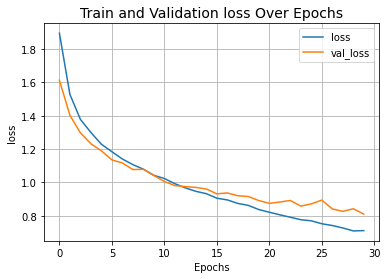

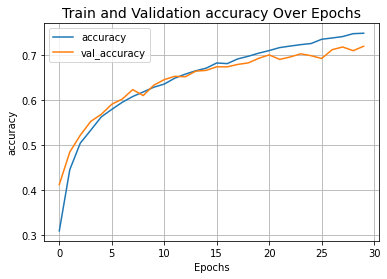

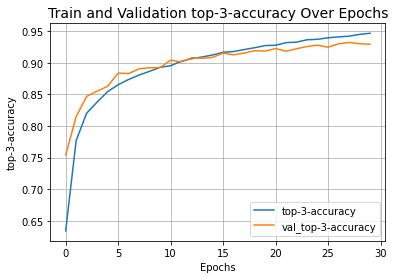

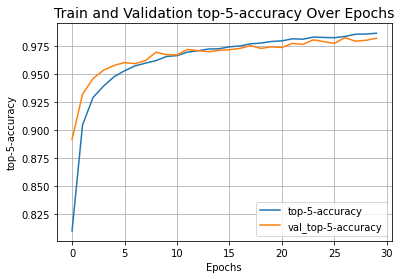

In [7]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")
plot_result("top-3-accuracy")
plot_result("top-5-accuracy")